In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os, wget

import cupy as cp
import cudf

from cuml.decomposition import PCA
from cuml.manifold import TSNE
from cuml.cluster import KMeans
from cuml.preprocessing import StandardScaler

import rapids_scanpy_funcs
import utils

import warnings
warnings.filterwarnings('ignore', 'Expected ')
warnings.simplefilter('ignore')
import pandas as pd
from sh import gunzip
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
import rmm

rmm.reinitialize(managed_memory=True)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)

import calculation_tool as ct

In [11]:
Ac_csv_path=r"/temp/data/human_sz_H3K27ac/H3K27ac_Sz_vs_Ctrl_genename_translated.csv"
Ac_peak=cudf.read_csv(Ac_csv_path,usecols=list(range(12)[1:]))

In [13]:
Sz_DEG_path=r"/temp/data/human_Sz_PFC/Supplementary_Dataset_Tables_1_DEgene_by_cluster.csv"
DEG=cudf.read_csv(Sz_DEG_path,header=2,usecols=list(range(11)))

In [18]:
DEG_visium_path=r"/temp/data/human_Sz_PFC/Supplementary_Dataset_Tables_1_DEG_from_visium.csv"
DEG_visium=cudf.read_csv(DEG_visium_path,header=2,usecols=list(range(8)))

In [6]:
DEG

,Cell_type,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Z,Za,Gene,CellFrac
0,ID2_LAMP5_CRH,179.020139,3.690539,0.619698,5.955386,2.594590e-09,0.000032,5.955386,4.158437,FP236383.1,0.197651
1,ID2_LAMP5_CRH,392.829013,2.677073,0.534075,5.012541,5.371600e-07,0.003317,5.012541,2.936727,AC060765.2,0.439076
2,ID2_LAMP5_CRH,19.161573,2.253747,0.467808,4.817670,1.452440e-06,0.005979,4.817670,2.748919,HES4,0.051381
3,ID2_LAMP5_CRH,241.096194,0.786414,0.168531,4.666290,3.066860e-06,0.009469,4.666290,2.594642,CHD5,0.508475
4,ID2_LAMP5_CRH,175.496007,0.411861,0.090762,4.537795,5.684540e-06,0.013078,4.537795,2.481647,CDC42BPB,0.420659
...,...,...,...,...,...,...,...,...,...,...,...
462626,VIP_TYR,23.190007,0.000076,0.210195,0.000361,9.997120e-01,0.999893,0.000361,0.000134,MAPT-AS1,0.170178
462627,VIP_TYR,12.190690,0.000109,0.313975,0.000348,9.997224e-01,0.999893,0.000348,0.000134,HAPLN1,0.085253
462628,VIP_TYR,5.536959,-0.000127,0.366415,-0.000346,9.997237e-01,0.999893,-0.000346,-0.000134,TMEM202-AS1,0.050033
462629,VIP_TYR,15.295388,0.000026,0.230134,0.000115,9.999082e-01,0.999984,0.000115,0.000020,CETN3,0.120474


In [12]:
Ac_peak

,seqnames,start,end,PeakID,logFC,AveExpr,t,P.Value,adj.P.Val,B,gene_name
0,chr1,1680508,1681802,peak_100,-0.010898,1.292553,-0.216367,0.828868,0.917298,-6.024810,SLC35E2B
1,chr1,15884473,15887148,peak_1000,0.098750,2.419149,2.366058,0.018698,0.106288,-3.495232,SPEN
2,chr1,226600116,226610533,peak_10000,0.051667,4.641729,1.613007,0.107933,0.295068,-5.077618,STUM
3,chr16,10685721,10686372,peak_100000,-0.039854,-0.222136,-0.811359,0.417888,0.639486,-5.545350,TEKT5
4,chr16,10727917,10730066,peak_100001,0.024694,2.269825,0.609189,0.542921,0.736718,-5.959900,<NA>
...,...,...,...,...,...,...,...,...,...,...,...
114118,chr16,10608475,10609761,peak_99995,-0.036485,1.984186,-1.080755,0.280788,0.513221,-5.555664,<NA>
114119,chr16,10617931,10620203,peak_99996,-0.013285,2.271125,-0.228018,0.819808,0.912225,-6.112722,<NA>
114120,chr16,10660882,10669000,peak_99997,-0.101608,4.316751,-1.709514,0.088526,0.262816,-4.900436,TEKT5
114121,chr16,10675068,10675868,peak_99998,-0.099226,0.701202,-1.692527,0.091721,0.268326,-4.640552,TEKT5


In [19]:
DEG_visium

,Layer,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,Gene
0,L1,0.310441,1.897826,2.739238,0.788930,0.374424,1,AL627309.1
1,L1,0.332856,0.232693,2.805509,-0.038804,1.000000,1,AL627309.6
2,L1,0.289488,-0.008378,2.937587,-0.051552,1.000000,1,AL627309.5
3,L1,0.883136,0.914387,1.677021,0.333939,0.563349,1,AP006222.1
4,L1,0.112765,1.365048,3.504369,-0.032611,1.000000,1,AL669831.3
...,...,...,...,...,...,...,...,...
148016,L6,50.557110,0.187029,0.259919,0.522485,0.469783,1,AC007325.4
148017,L6,2.753302,0.425033,0.626855,0.623166,0.429873,1,AC007325.2
148018,L6,0.366770,0.954055,2.122129,0.399569,0.527312,1,AL354822.1
148019,L6,5.570541,1.499958,2.932210,0.237435,0.626065,1,AC004556.1


In [39]:
def get_common_genes(DEG, Ac_peak, pval_threshold, foldchange_threshold):
    
    # DEGから指定されたしきい値で絞り込む
    filtered_DEG = DEG[DEG['padj'] < pval_threshold]
    filtered_DEG = filtered_DEG[filtered_DEG['log2FoldChange'].abs() > foldchange_threshold]
    
    # Ac_peakから指定されたしきい値で絞り込む
    filtered_Ac_peak = Ac_peak[Ac_peak['adj.P.Val'] < pval_threshold]
    filtered_Ac_peak = filtered_Ac_peak[filtered_Ac_peak['logFC'].abs() > foldchange_threshold]
    
    # 共通のgene_nameを取得
    common_genes = filtered_DEG.merge(filtered_Ac_peak, left_on='Gene', right_on='gene_name', how='inner')
    
    return common_genes['gene_name'].unique()

# 例として、pval_thresholdを0.05、foldchange_thresholdを1として関数を実行
common_genes_result = get_common_genes(DEG, Ac_peak, 0.05, 0.1)
print(common_genes_result)

0         ADARB2
1         BABAM2
2        CACNA1B
3       CDC42BPB
4        CNTNAP5
5        FAM193A
6         GPR176
7          GRID2
8           HES4
9        LDLRAD4
10     LINC02196
11          MAP6
12          MSRA
13         MYO9B
14         OPCML
15         PACRG
16        PRKAG2
17      RAP1GAP2
18         RPRD2
19         SCN2B
20      SLC16A10
21      SLC30A10
22          SMG6
23    ST6GALNAC3
Name: gene_name, dtype: object


In [53]:
def genes_expression_change_by_cell_type(common_genes, DEG, foldchange_threshold, pval_threshold):
    # 共通遺伝子をDEGデータフレームでフィルタリング
    filtered_DEG = DEG[DEG['Gene'].isin(common_genes)]
    
    # foldchangeとpvalで絞り込み
    significant_DEG = filtered_DEG[(filtered_DEG['log2FoldChange'].abs() > foldchange_threshold) & 
                                  (filtered_DEG['pvalue'] < pval_threshold)]
    
    # 遺伝子とCell_typeのペアを返す
    return significant_DEG[['Gene', 'Cell_type', 'log2FoldChange', 'pvalue']]

# 例として、common_genes_across_dfsとDEGを使用して関数を実行
foldchange_threshold = 0.1
pval_threshold = 0.05
expression_change_by_cell_types = genes_expression_change_by_cell_type(common_genes_result, DEG, foldchange_threshold, pval_threshold)
print(expression_change_by_cell_types)
csv_path=r"/temp/data/human_Sz_PFC/common_differential_gene_n_cell_type.csv"
expression_change_by_cell_types.to_csv(csv_path)


            Gene      Cell_type  log2FoldChange    pvalue
2           HES4  ID2_LAMP5_CRH        2.253747  0.000001
4       CDC42BPB  ID2_LAMP5_CRH        0.411861  0.000006
16         PACRG  ID2_LAMP5_CRH        0.564407  0.000073
29      SLC30A10  ID2_LAMP5_CRH        0.917638  0.000371
35         RPRD2  ID2_LAMP5_CRH        0.276269  0.000457
...          ...            ...             ...       ...
438116  SLC16A10      VIP_SSTR1        0.334332  0.023870
438322    PRKAG2      VIP_SSTR1        0.261123  0.034226
451180   CACNA1B        VIP_TYR        0.229837  0.018620
451350  CDC42BPB        VIP_TYR        0.254850  0.030605
451649     MYO9B        VIP_TYR        0.318254  0.049896

[313 rows x 4 columns]


In [52]:
import numpy as np
import pandas as pd
print((pd.DataFrame(expression_change_by_cell_types))

TypeError: Implicit conversion to a host NumPy array via __array__ is not allowed, To explicitly construct a GPU matrix, consider using .as_gpu_matrix()
To explicitly construct a host matrix, consider using .as_matrix()

In [36]:
def filter_dataframe(df, pval_column, fc_column, pval_threshold, foldchange_threshold):
    # padjでのフィルタリング
    filtered_df = df[df[pval_column] < pval_threshold]
    # log2FoldChangeの絶対値でのフィルタリング
    filtered_df = filtered_df[filtered_df[fc_column].abs() > foldchange_threshold]
    return filtered_df

# DEG_visiumに対しての絞り込み
filtered_DEG_visium = filter_dataframe(DEG_visium, 'padj', 'log2FoldChange', 0.05, 0.05)
print("Filtered DEG_visium:\n", filtered_DEG_visium)

# DEGに対しての絞り込み
filtered_DEG = filter_dataframe(DEG, 'padj', 'log2FoldChange', 0.05, 0.1)
print("\nFiltered DEG:\n", filtered_DEG)

# Ac_peakに対しての絞り込み
filtered_Ac_peak = filter_dataframe(Ac_peak, 'adj.P.Val', 'logFC', 0.05, 0.1)
print("\nFiltered Ac_peak:\n", filtered_Ac_peak)

Filtered DEG_visium:
       Layer  baseMean  log2FoldChange     lfcSE      stat    pvalue  padj  \
44076    L3  29.11827        0.974268  0.228020  18.48088  0.000017     0   
71756    L4  19.39901       -1.563169  0.364731  18.28086  0.000019     0   

          Gene  
44076  SLCO1A2  
71756     NQO1  

Filtered DEG:
             Cell_type    baseMean  log2FoldChange     lfcSE      stat  \
0       ID2_LAMP5_CRH  179.020139        3.690539  0.619698  5.955386   
1       ID2_LAMP5_CRH  392.829013        2.677073  0.534075  5.012541   
2       ID2_LAMP5_CRH   19.161573        2.253747  0.467808  4.817670   
3       ID2_LAMP5_CRH  241.096194        0.786414  0.168531  4.666290   
4       ID2_LAMP5_CRH  175.496007        0.411861  0.090762  4.537795   
...               ...         ...             ...       ...       ...   
425089     VIP_SEMA3C   12.506572        0.984955  0.217906  4.520085   
425090     VIP_SEMA3C   61.229001        0.666643  0.150239  4.437206   
450847        VIP_TYR 

In [37]:
def get_common_genes_across_dfs(df1, df2, df3, gene_column_name1, gene_column_name2, gene_column_name3):
    # 各データフレームから遺伝子名を抽出
    genes_df1 = set(df1[gene_column_name1].to_array())
    genes_df2 = set(df2[gene_column_name2].to_array())
    genes_df3 = set(df3[gene_column_name3].to_array())
    
    # 3つのデータフレームで共通の遺伝子を抽出
    common_genes = genes_df1.intersection(genes_df2).intersection(genes_df3)
    
    return common_genes

# 3つの絞り込まれたデータフレームで共通の遺伝子を抽出
common_genes_across_dfs = get_common_genes_across_dfs(filtered_DEG_visium, filtered_DEG, filtered_Ac_peak, 'Gene', 'Gene', 'gene_name')

print(common_genes_across_dfs)

set()


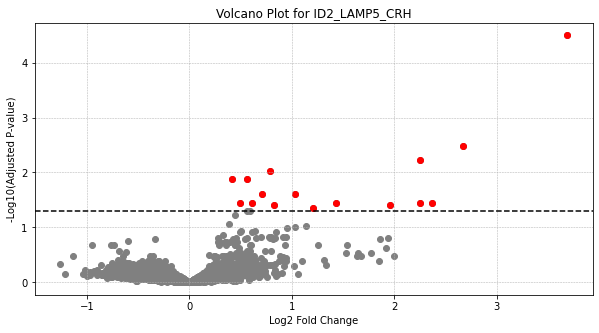

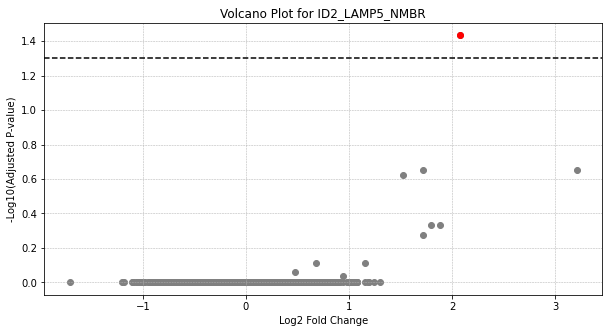

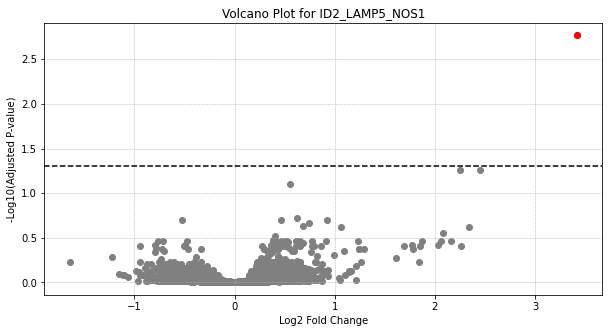

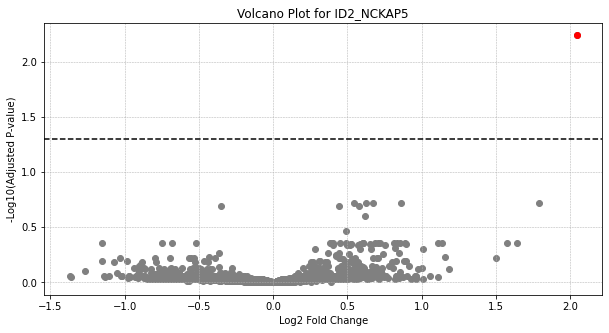

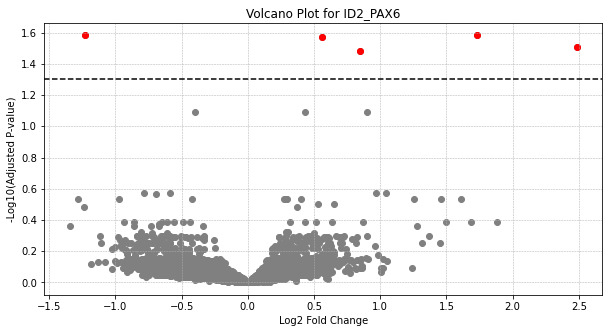

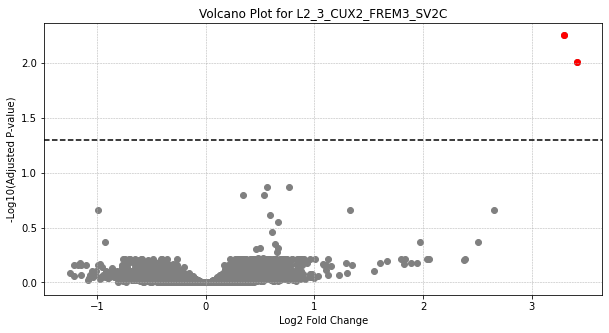

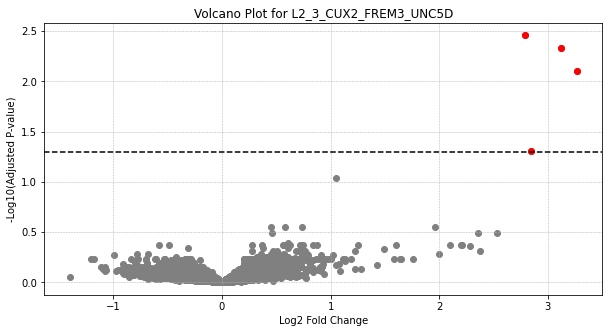

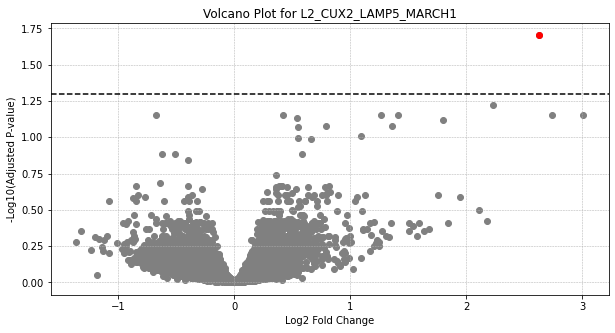

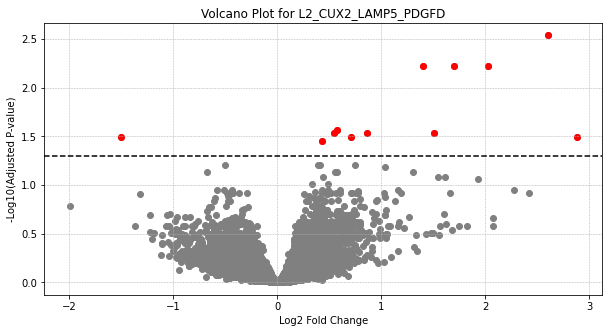

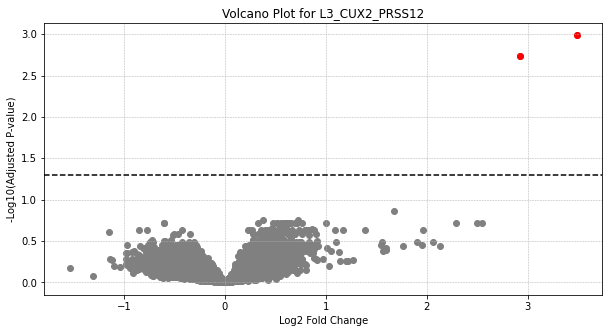

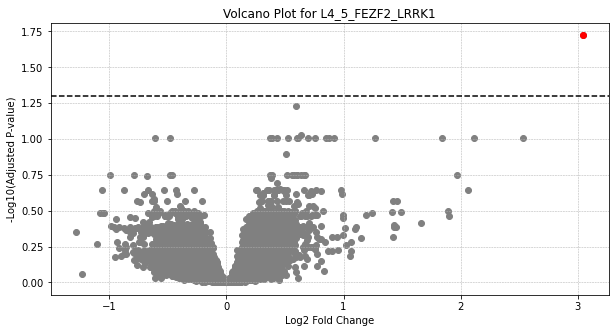

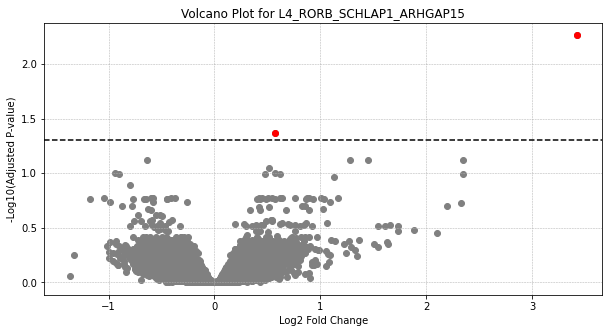

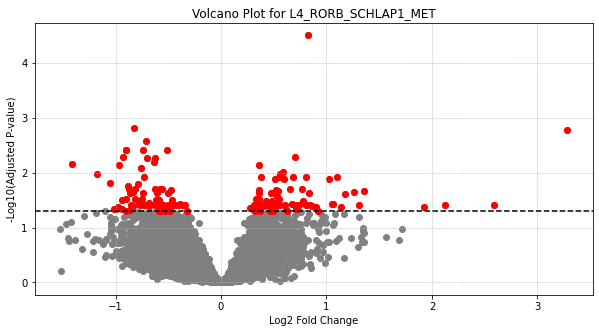

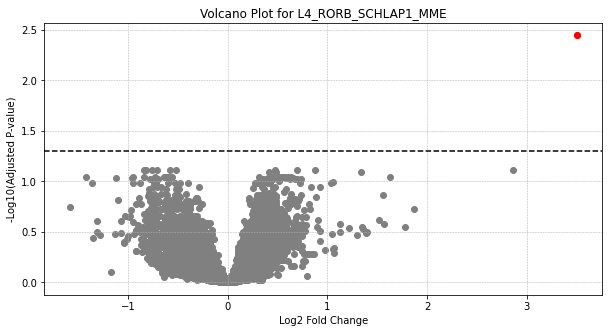

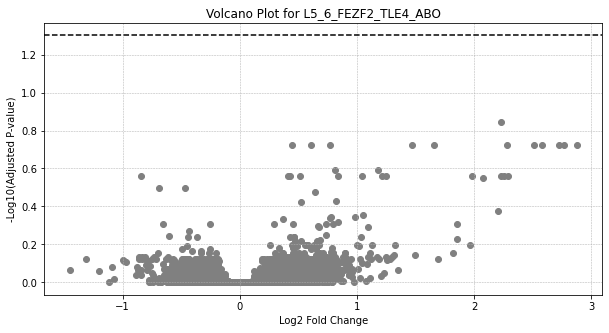

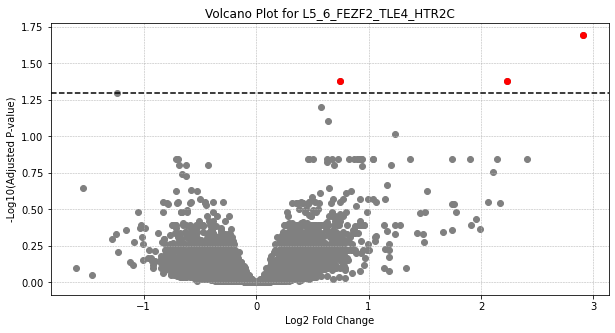

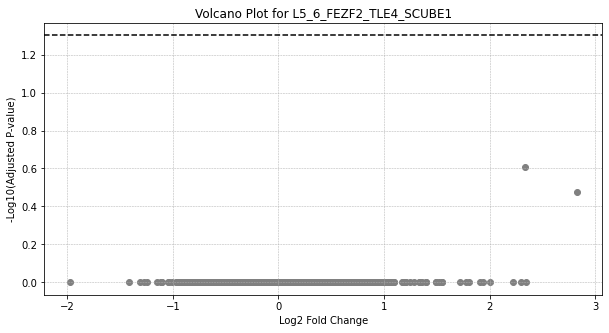

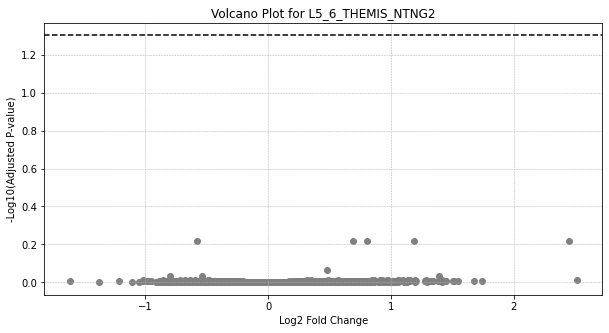

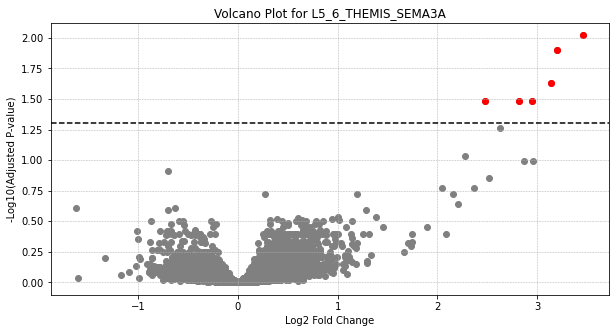

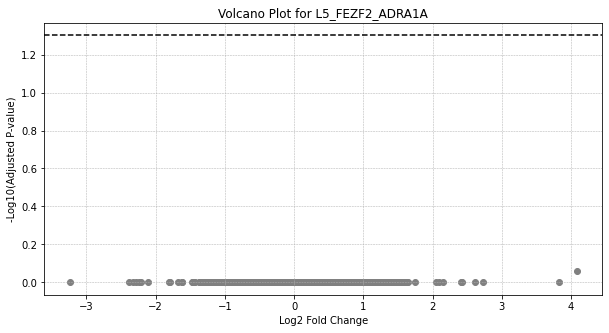

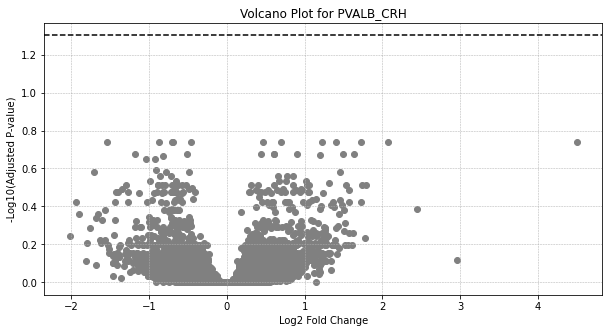

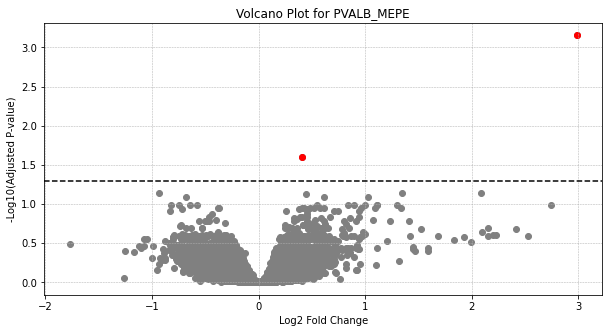

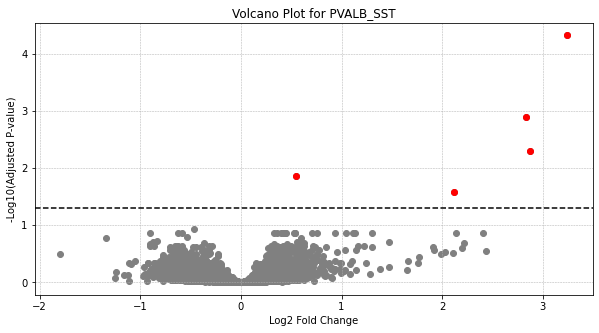

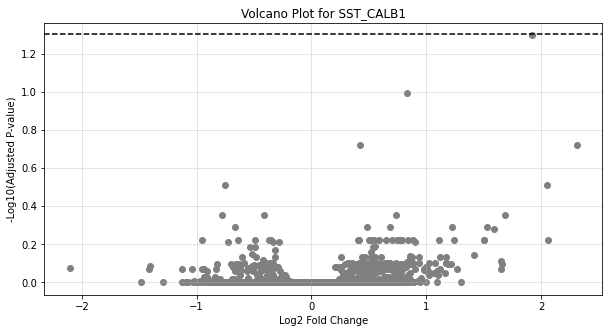

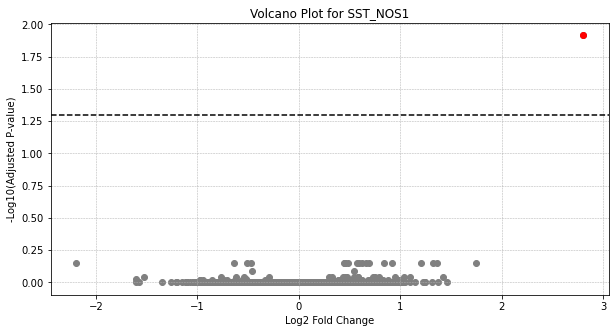

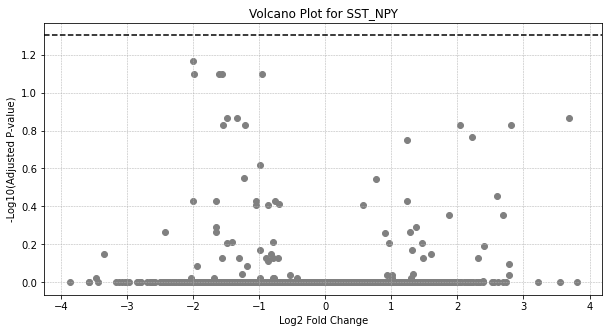

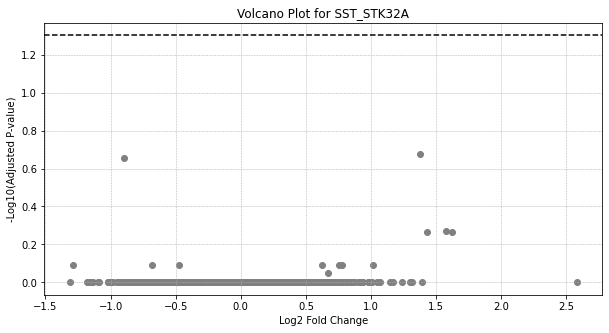

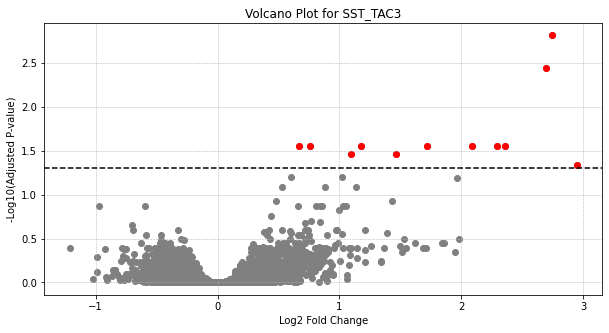

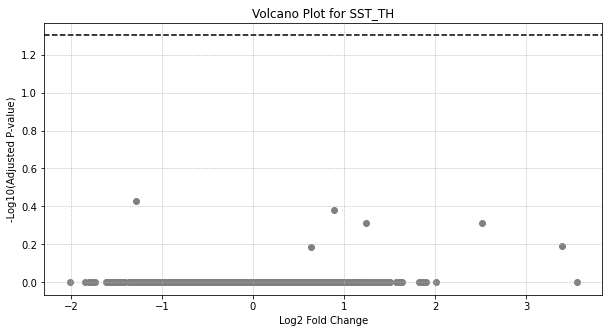

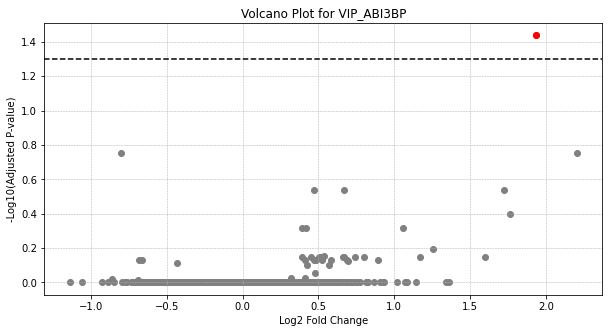

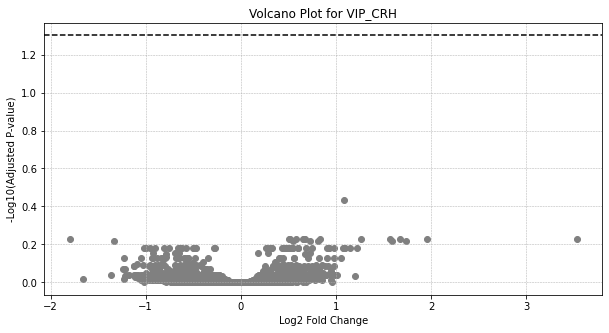

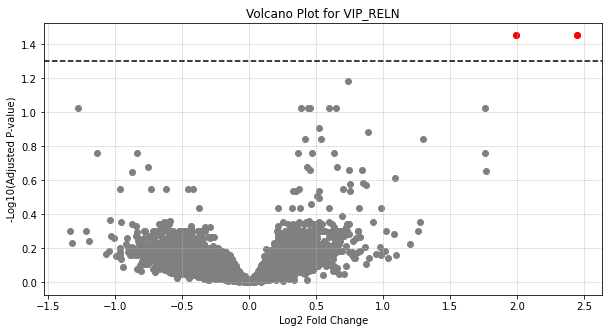

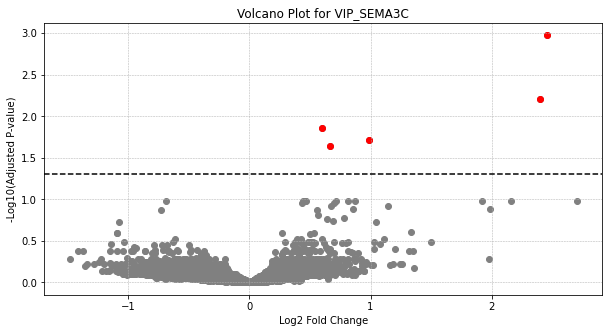

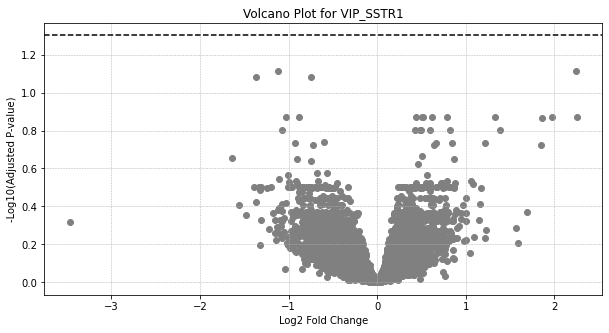

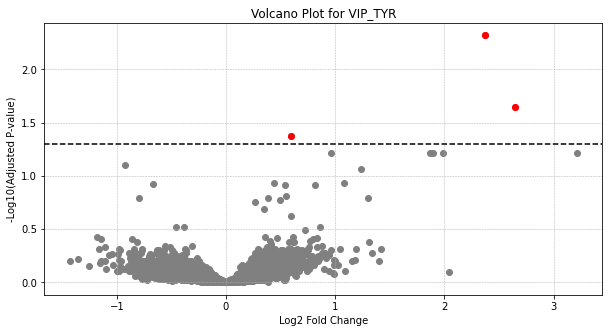

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# データフレームの読み込み（仮にdfという名前で読み込むことを想定）
# df = pd.read_csv("your_data.csv")

def plot_volcano_for_celltype(df, celltype):
    sub_df = df[df['Cell_type'] == celltype]
    
    plt.figure(figsize=(10, 5))
    
    # NaN values handling
    sub_df = sub_df.dropna(subset=['padj', 'log2FoldChange'])
    
    # Convert data to host-side numpy array using .to_array()
    log2FoldChange_np = sub_df['log2FoldChange'].to_array()
    padj_np = sub_df['padj'].to_array()
    
    plt.scatter(log2FoldChange_np, -np.log10(padj_np), color='gray')
    plt.scatter(log2FoldChange_np[padj_np < 0.05], -np.log10(padj_np[padj_np < 0.05]), color='red')
    
    plt.title(f"Volcano Plot for {celltype}")
    plt.xlabel('Log2 Fold Change')
    plt.ylabel('-Log10(Adjusted P-value)')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.axhline(y=-np.log10(0.05), color='black', linestyle='--')
    plt.show()

# すべてのユニークなcell typeに対してvolcano plotを表示
for celltype in DEG['Cell_type'].unique().to_pandas():
    plot_volcano_for_celltype(DEG, celltype)